Read in Argoverse HD map and COLMAP results

In [1]:
from transforms import affine_matrix_from_points
from argoverse.data_loading.argoverse_tracking_loader import ArgoverseTrackingLoader
from scipy.spatial import transform
import matplotlib
import matplotlib.pyplot as plt
from visualize_30hz_benchmark_data_on_map import DatasetOnMapVisualizer
from argoverse.map_representation.map_api import ArgoverseMap
import logging
import numpy as np
import numpy.linalg as LA

# path to the argoverse dataset
tracking_dataset_dir = '../argoverse-tracking/sample/'

# log_index determines which log in the argoverse dataset directory to use
log_index = 0

# load argoverse HD map
argoverse_loader = ArgoverseTrackingLoader(tracking_dataset_dir)
log_id = argoverse_loader.log_list[log_index]
argoverse_data = argoverse_loader[log_index]

am = ArgoverseMap()
city_name = argoverse_data.city_name
dataset_dir = tracking_dataset_dir
experiment_prefix = 'visualization_demo'
use_existing_files = True

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
domv = DatasetOnMapVisualizer(dataset_dir, experiment_prefix, use_existing_files=use_existing_files, log_id=argoverse_data.current_log)

# colmap_output_dir points to the results from COLMAP
colmap_output_dir = 'reconstruction/sparse/' + log_id + '/'
# detection results directory
detection_output_dir = './focal_detection/'
# where to save computed traffic sign locations
projection_output_dir = './'


# flags that determine which ring cameras to use
use_fc, use_fl, use_sl, use_rl, use_rr, use_sr, use_fr = [1, 1, 0, 0, 0, 0, 0]

#read in colmap results
poses_colmap = dict()   #dict that queries camera poses with image name
points_colmap = dict()  #dict that queries colmap feature points IDs with image name
id2name_colmap = dict() #dict that queries image name with colmap image IDs
points3D = dict()       #dict that queries colmap points' 3D coordinates with colmap point IDs

with open(colmap_output_dir + 'images.txt') as f:
    lines = f.read().splitlines()
for i,line in enumerate(lines):
    if line[0] == '#':
        continue
    else:
        if i % 2 == 0:
            fields = line.split(' ')
            image_name = fields[-1]
            image_id = int(fields[0])
            quat = fields[1:5]
            quatanion = np.array([float(q) for q in quat])
            trans = fields[5:8]
            translation = np.array([float(t) for t in trans])
            camera_id = int(fields[8])
            poses_colmap[image_name] = [quatanion, translation, image_id, camera_id]
            id2name_colmap[image_name] = image_id
        else:
            fields = line.split(' ')
            points_2d = np.array([float(pt) for pt in fields])
            points_colmap[image_name] = points_2d
            
with open(colmap_output_dir + 'points3D.txt') as f:
    lines = f.read().splitlines()
for i,line in enumerate(lines):
    if line[0] == '#':
        continue
    else: 
            fields = line.split(' ')
            points_attr = np.array([float(pt) for pt in fields])
            points3D[points_attr[0]] = np.array([points_attr[1],points_attr[2],points_attr[3]])
            

INFO:argoverse.data_loading.synchronization_database:Building SynchronizationDB
INFO:root:syncronizing camera and lidar sensor...
INFO:argoverse.data_loading.vector_map_loader:Loaded root: ArgoverseVectorMap
INFO:argoverse.data_loading.vector_map_loader:Loaded root: ArgoverseVectorMap


Compute the 3D-to-3D similarity Transformation M from Argoverse coordinates to COLMAP coordinates. If you want to load a pre-computed M, you can skip this cell.

In [2]:
# read in argoverse ground truth camera poses
calibration_ring_front_center = argoverse_data.get_calibration("ring_front_center")
calibration_ring_front_left = argoverse_data.get_calibration("ring_front_left")
calibration_ring_side_left = argoverse_data.get_calibration("ring_side_left")
calibration_ring_rear_left = argoverse_data.get_calibration("ring_rear_left")
calibration_ring_rear_right = argoverse_data.get_calibration("ring_rear_right")
calibration_ring_side_right = argoverse_data.get_calibration("ring_side_right")
calibration_ring_front_right = argoverse_data.get_calibration("ring_front_right")


# establish 3D-to-3D points correspondances
argo_3d = []     # save camera 3D positions in argoverse coordinate 
colmap_3d = []   # save camera 3D positions in colmap coordinate
for idx in range(len(argoverse_data.image_list_sync['ring_front_center'])):
    city_to_egovehicle_se3 = argoverse_data.get_pose(idx)
    
    # establish points correspondances using ring front camera positions
    if use_fc:
        argo_pt = city_to_egovehicle_se3.transform_point_cloud(
            calibration_ring_front_center.project_cam_to_ego(np.zeros((1,3))))[0]
    
        img_fc = argoverse_data.image_list_sync['ring_front_center'][idx]
        img_fc = img_fc.split('/')
        img_fc = img_fc[-2] + '/' + img_fc[-1]
        if img_fc in poses_colmap.keys():
            q = poses_colmap[img_fc][0]
            quat = [q[1], q[2], q[3], q[0]]
            R = transform.Rotation.from_quat(quat)
            t = poses_colmap[img_fc][1]
            colmap_pt = - R.as_matrix().T.dot(t) 
            colmap_3d.append(colmap_pt)
            argo_3d.append(argo_pt)
            
# establish points correspondances using other ring camera positions     
for idx in range(len(argoverse_data.image_list_sync['ring_front_center'])):
    city_to_egovehicle_se3 = argoverse_data.get_pose(idx)    
    if use_fr:
        argo_pt = city_to_egovehicle_se3.transform_point_cloud(
            calibration_ring_front_right.project_cam_to_ego(np.zeros((1,3))))[0]
        img_fr = argoverse_data.image_list_sync['ring_front_right'][idx]
        img_fr = img_fr.split('/')
        img_fr = img_fr[-2] + '/' + img_fr[-1]
        if img_fr in poses_colmap.keys():
            q = poses_colmap[img_fr][0]
            quat = [q[1], q[2], q[3], q[0]]
            R = transform.Rotation.from_quat(quat)
            t = poses_colmap[img_fr][1]
            colmap_pt = - R.as_matrix().T.dot(t) 
            colmap_3d.append(colmap_pt)
            argo_3d.append(argo_pt)
    if use_fl:
        argo_pt = city_to_egovehicle_se3.transform_point_cloud(
            calibration_ring_front_left.project_cam_to_ego(np.zeros((1,3))))[0]
        img_fl = argoverse_data.image_list_sync['ring_front_left'][idx]
        img_fl = img_fl.split('/')
        img_fl = img_fl[-2] + '/' + img_fl[-1]
        if img_fl in poses_colmap.keys():
            q = poses_colmap[img_fl][0]
            quat = [q[1], q[2], q[3], q[0]]
            R = transform.Rotation.from_quat(quat)
            t = poses_colmap[img_fl][1]
            colmap_pt = - R.as_matrix().T.dot(t) 
            colmap_3d.append(colmap_pt)
            argo_3d.append(argo_pt)
    if use_sl:
        argo_pt = city_to_egovehicle_se3.transform_point_cloud(
            calibration_ring_side_left.project_cam_to_ego(np.zeros((1,3))))[0]
        img_sl = argoverse_data.image_list_sync['ring_side_left'][idx]
        img_sl = img_sl.split('/')
        img_sl = img_sl[-2] + '/' + img_sl[-1]
        if img_sl in poses_colmap.keys():
            q = poses_colmap[img_sl][0]
            quat = [q[1], q[2], q[3], q[0]]
            R = transform.Rotation.from_quat(quat)
            t = poses_colmap[img_sl][1]
            colmap_pt = - R.as_matrix().T.dot(t) 
            colmap_3d.append(colmap_pt)
            argo_3d.append(argo_pt)
    if use_sr:
        argo_pt = city_to_egovehicle_se3.transform_point_cloud(
            calibration_ring_side_right.project_cam_to_ego(np.zeros((1,3))))[0]
        img_sr = argoverse_data.image_list_sync['ring_side_right'][idx]
        img_sr = img_sr.split('/')
        img_sr = img_sr[-2] + '/' + img_sr[-1]
        if img_sr in poses_colmap.keys():
            q = poses_colmap[img_sr][0]
            quat = [q[1], q[2], q[3], q[0]]
            R = transform.Rotation.from_quat(quat)
            t = poses_colmap[img_sr][1]
            colmap_pt = - R.as_matrix().T.dot(t) 
            colmap_3d.append(colmap_pt)
            argo_3d.append(argo_pt)
    if use_rl:
        argo_pt = city_to_egovehicle_se3.transform_point_cloud(
            calibration_ring_rear_left.project_cam_to_ego(np.zeros((1,3))))[0]
        img_rl = argoverse_data.image_list_sync['ring_rear_left'][idx]
        img_rl = img_rl.split('/')
        img_rl = img_rl[-2] + '/' + img_rl[-1]
        if img_rl in poses_colmap.keys():
            q = poses_colmap[img_rl][0]
            quat = [q[1], q[2], q[3], q[0]]
            R = transform.Rotation.from_quat(quat)
            t = poses_colmap[img_rl][1]
            colmap_pt = - R.as_matrix().T.dot(t) 
            colmap_3d.append(colmap_pt)
            argo_3d.append(argo_pt)
    if use_rr:
        argo_pt = city_to_egovehicle_se3.transform_point_cloud(
            calibration_ring_rear_right.project_cam_to_ego(np.zeros((1,3))))[0]
        img_rr = argoverse_data.image_list_sync['ring_rear_right'][idx]
        img_rr = img_rr.split('/')
        img_rr = img_rr[-2] + '/' + img_rr[-1]
        if img_rr in poses_colmap.keys():
            q = poses_colmap[img_rr][0]
            quat = [q[1], q[2], q[3], q[0]]
            R = transform.Rotation.from_quat(quat)
            t = poses_colmap[img_rr][1]
            colmap_pt = - R.as_matrix().T.dot(t) 
            colmap_3d.append(colmap_pt)
            argo_3d.append(argo_pt)

            
             
# compute 3D-to-3D similarity transformation from argoverse to colmap            
points_3d_argo = np.array(argo_3d)
points_3d_colmap = np.array(colmap_3d)
M = affine_matrix_from_points(points_3d_colmap[:,:].T, points_3d_argo[:,:].T, shear=False)
M_inv = affine_matrix_from_points(points_3d_argo[:,:].T, points_3d_colmap[:,:].T, shear=False)

Functions that convert each detection bounxing box into a 3D traffic sign position in Argoevrse coordinate

In [3]:
import cv2 
import os
import numpy as np

# read in detection results
boxes = np.load(detection_output_dir + log_id + '.npz',allow_pickle=True)
boxes_images_list = [full_name.split('/')[-1] for full_name in boxes['input_image_names']]   
order = np.argsort(boxes_images_list)
boxes_images_list = np.array(boxes_images_list)[order]    # image names for the detection bounding boxes
boxes_boxes_list = boxes['bbox_list'][order]              # detection bounding boxes
boxes_scores_list = boxes['score_list'][order]            # confidence scores for the detection bounding boxes
boxes_class_list = boxes['pred_classes_list'][order]      # detected categories for the detection bounding boxes


# Check whether a point is inside a detection bounding box
def check_inside(x1, y1, x2, y2, x, y):
    return x1 <= x and x <= x2 and y1 <= y and y <=y2


# Project all feature points in a detection bounding box into a single traffic sign position in Argoverse coordinate
def bbox2argoverse(x1, y1, x2, y2, points_colmap, points3D, M, image_name):
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    flag = False  # will be true if there is not a single feature point in a detection bounxing box
    insider = []  # save all the colmap feature points that are within the detection bounxing box
    for i in range(int( len(points_colmap[image_name]) // 3)):
        x = points_colmap[image_name][3*i]
        y = points_colmap[image_name][3*i + 1] 
        idx = points_colmap[image_name][3*i + 2] 
        if check_inside(x1,y1, x2, y2, x,y) and idx != -1:
            dist = (x - center_x) * (x - center_x) + (y - center_y) * (y - center_y)
            insider.append([x,y,idx,dist])
    if len(insider) <= 0:
        print("No feature points detected in the bounding box")
        flag = True
        return 0, flag, 0
    elif len(insider) > 3:
        # each traffic sign's position is represented as the avegerage position of its center most 3 feature points
        print("More than 3 points detected in the bounding box")
        insider = np.array(insider)
        insider.view('f8,f8,f8,f8').sort(order=['f3'], axis=0)
        pts_colmap = np.zeros((3,3))
        pts_colmap[:,0] = points3D[insider[0,2]] #-1,2
        pts_colmap[:,1] = points3D[insider[1,2]] #-2,2
        pts_colmap[:,2] = points3D[insider[2,2]] #-3,2
        pts_homo = np.vstack([pts_colmap,np.ones(3)])
        pts_argo = M @ pts_homo
        return np.mean(pts_argo, axis=1), flag, np.mean(pts_colmap, axis = 1)
    else:
        print("Less than 3 points detected in the bounding box")
        pts_colmap = []
        for i,line in enumerate(insider):
              pts_colmap.append(points3D[insider[i][2]])
        pts_colmap = np.array(pts_colmap)
        pts_colmap = pts_colmap.T
        pts_homo = np.vstack([pts_colmap,np.ones(pts_colmap.shape[1])])
        pts_argo = M @ pts_homo
        return np.mean(pts_argo, axis=1), flag, np.mean(pts_colmap, axis = 1)

# remove these detected signs that are too far away from the vehicle
def checkDistance(image_name, sign_position):
    q = poses_colmap[image_name][0]
    quat = [q[1], q[2], q[3], q[0]]
    R = transform.Rotation.from_quat(quat)
    t = poses_colmap[image_name][1]
    vehicle_position_colmap = - R.as_matrix().T.dot(t)
    vehicle_position_argo = M.dot(np.append(vehicle_position_colmap, [1]))
    L2_distance = np.sqrt(np.sum(np.square(vehicle_position_argo[:3] - sign_position)))
    return L2_distance

Convert each detection bounxing box in to a 3D traffic sign position in Argoverse coordinate

In [4]:
# Convert each detection bounxing box in to a traffic sign position in Argoverse coordinate
signs = []       # save all traffic sign positions in argoverse coordinate
signs_col = []   # save all traffic sign positions in colmap coordinate
names = []       # save the image names for each detected traffic sign
scores = []      # save the confidence scores for each detected traffic sign
classes = []     # save the categories for each detected traffic sign
for j in range(len(boxes_images_list)):
    image_name = 'ring_front_center/' + boxes_images_list[j]
    if os.path.exists(tracking_dataset_dir + log_id + '/' + image_name):
        im = cv2.imread(tracking_dataset_dir + log_id + '/'+ image_name)
        for cc,box in enumerate(boxes_boxes_list[j]):
            x1  = int(box[0])
            y1 = int(box[1])
            x2 = int(box[2])
            y2 = int(box[3])
            # discard those bounding boxes that are too small
            if (y2-y1) * (x2-x1) < 500:
                continue
            if image_name not in points_colmap.keys():
                continue
            argo_box, flag, colmap_box =  bbox2argoverse(x1,y1,x2,y2,points_colmap,points3D,M,image_name)
            if flag: 
                continue
            # discard those detected signs that are too far from the vehicle
            distance_2_sign = checkDistance(image_name, argo_box[:3])
            if distance_2_sign > 50:
                continue
            signs.append([argo_box[0], argo_box[1], argo_box[2]])
            names.append(image_name)
            scores.append(boxes_scores_list[j][cc])
            classes.append(boxes_class_list[j][cc])
            signs_col.append(colmap_box)

No feature points detected in the bounding box
Less than 3 points detected in the bounding box
Less than 3 points detected in the bounding box
No feature points detected in the bounding box
Less than 3 points detected in the bounding box
No feature points detected in the bounding box
More than 3 points detected in the bounding box
No feature points detected in the bounding box
More than 3 points detected in the bounding box
More than 3 points detected in the bounding box
More than 3 points detected in the bounding box
More than 3 points detected in the bounding box
Less than 3 points detected in the bounding box
More than 3 points detected in the bounding box
Less than 3 points detected in the bounding box
More than 3 points detected in the bounding box
Less than 3 points detected in the bounding box
Less than 3 points detected in the bounding box
More than 3 points detected in the bounding box
More than 3 points detected in the bounding box
Less than 3 points detected in the bounding 

More than 3 points detected in the bounding box
No feature points detected in the bounding box
More than 3 points detected in the bounding box
More than 3 points detected in the bounding box
No feature points detected in the bounding box
More than 3 points detected in the bounding box
More than 3 points detected in the bounding box
More than 3 points detected in the bounding box
No feature points detected in the bounding box
More than 3 points detected in the bounding box
More than 3 points detected in the bounding box
Less than 3 points detected in the bounding box
More than 3 points detected in the bounding box
More than 3 points detected in the bounding box
More than 3 points detected in the bounding box
Less than 3 points detected in the bounding box
More than 3 points detected in the bounding box
Less than 3 points detected in the bounding box
More than 3 points detected in the bounding box
Less than 3 points detected in the bounding box
More than 3 points detected in the bounding

Post-processing step to remove duplicated detections

In [5]:
# Remove duplicated detections
db_signs = []    # save the traffic sign postions for each unique sign
db_counts = []   # save the number of occurences (number of frames it is detected) for each unique sign
db_names = []    # save the image name for its first detected frame for each unique sign
db_classes = []  # save the category for each unique sign

# check whether two detection projections are too close too each other
def check_adjacency(sign, db_sign):
    l2 = np.sqrt((sign[0] - db_sign[0])**2 + (sign[1] - db_sign[1])**2)
    dz = np.absolute(sign[2] - db_sign[2])
    return l2 < 0.6 and dz < 0.4

# check if the detection categories are the same
def check_category(category, db_class):
    return category == db_class

# remove duplcated detections
for i in range(len(signs)):
    new_sign = True
    sign = signs[i]
    if i == 0:
        db_signs.append(sign)
        db_classes.append(classes[i])
        db_names.append(names[i])
        db_counts.append(1)
    else:
        for cc in range(len(db_signs)):
            db_sign = db_signs[cc]
            if check_adjacency(sign, db_sign) and check_category(classes[i], db_classes[cc]):
                new_sign = False
                db_counts[cc] += 1
                db_signs[cc] = 1 * sign + 0 * db_sign
                break
        if new_sign:
            db_signs.append(sign)
            db_classes.append(classes[i])
            db_names.append(names[i])
            db_counts.append(1)

signs = np.array(db_signs)
order = np.argsort(signs[:, 0])
db_signs = np.array(db_signs)[order]
db_classes = np.array(db_classes)[order]
db_names = np.array(db_names)[order]
db_counts = np.array(db_counts)[order]

for i in range(len(db_signs)):
    print(db_signs[i], db_classes[i], db_names[i], db_counts[i])
print(len(db_signs))

[2582.0357294  1200.57295546   19.60472327] 4 ring_front_center/ring_front_center_315978421317557848.jpg 3
[2585.35764868 1185.8461157    22.06255577] 4 ring_front_center/ring_front_center_315978412925957800.jpg 86
[2589.30029321 1205.73958472   17.52658219] 4 ring_front_center/ring_front_center_315978414624255144.jpg 15
[2599.54815885 1198.55306603   20.12784844] 4 ring_front_center/ring_front_center_315978413625254760.jpg 11
[2607.40562423 1223.21491884   18.13321268] 5 ring_front_center/ring_front_center_315978408030852032.jpg 39
[2616.09317101 1214.18193019   21.44940773] 3 ring_front_center/ring_front_center_315978409129760112.jpg 10
[2616.30310166 1213.93741302   20.72485961] 5 ring_front_center/ring_front_center_315978408030852032.jpg 36
[2621.26160336 1235.33445005   16.33128078] 4 ring_front_center/ring_front_center_315978409829057368.jpg 1
[2630.8958043  1244.42801696   17.32810022] 3 ring_front_center/ring_front_center_315978406032859416.jpg 31
[2631.00064277 1244.29213598  

Save the projection results into a npz file

In [11]:
# save detected traffic signs 
argo_sign_poses = db_signs
categories = db_classes
colmap2argo = M
argo2colmap = M_inv

np.savez(projection_output_dir + log_id+'_focal_projected.npz', 
         argo_sign_poses=argo_sign_poses, 
         categories=categories,
         colmap2argo=colmap2argo,
         argo2colmap=argo2colmap,
        )

Visualization

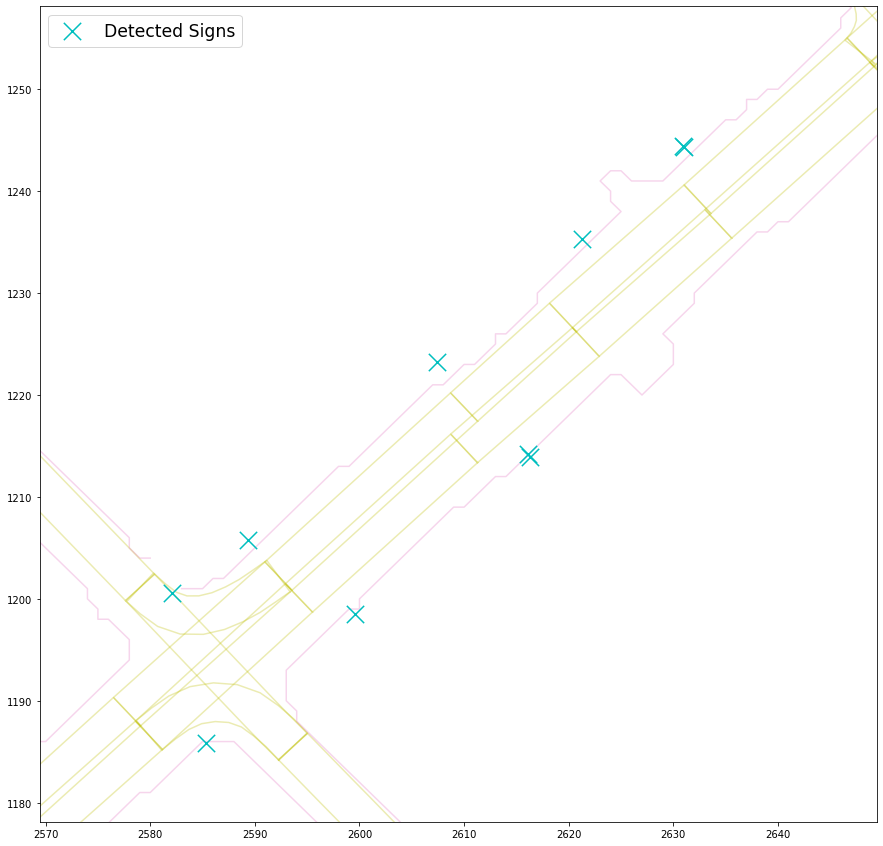

In [7]:
import copy

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)

xcenter = points_3d_argo[70,0]
ycenter = points_3d_argo[70,1]
   
xmin = xcenter - 40
xmax = xcenter + 40
ymin = ycenter - 40
ymax = ycenter + 40

points_3d_colmap_h = np.vstack([points_3d_colmap.T, np.ones(points_3d_colmap.shape[0])])
projected = M @ points_3d_colmap_h
ax.scatter(db_signs[:,0], db_signs[:,1] , 300, color="c", marker="x", zorder=2, label="Detected Signs")

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
local_lane_polygons = am.find_local_lane_polygons([xmin, xmax, ymin, ymax], city_name)
local_das = am.find_local_driveable_areas([xmin, xmax, ymin, ymax], city_name)

ax.legend(fontsize='xx-large')

domv.render_bev_labels_mpl_tmp( 
    city_name,
    ax,
    "city_axis",
    None,
    copy.deepcopy(local_lane_polygons),
    copy.deepcopy(local_das),
    city_to_egovehicle_se3,
    am,

)

plt.savefig("projection_results.png")

Extra: codes to visualize raw detection results

In [77]:
import numpy as np
import cv2
import os
import shutil
shutil.rmtree('images/vis_focal_detector/')
os.mkdir('images/vis_focal_detector/')

for idx in range(len(argoverse_data.image_list_sync['ring_front_center'])):
    img_fc = argoverse_data.image_list_sync['ring_front_center'][idx]
    img_fc = img_fc.split('/')[-1]
    box_idx = np.where(boxes_images_list == img_fc)[0]
    if not os.path.exists(tracking_dataset_dir + log_id + '/ring_front_center/' + img_fc):
        continue
    frame = cv2.imread(tracking_dataset_dir + log_id + '/ring_front_center/' + img_fc)
    if len(box_idx) != 0:
        box_idx = box_idx[0]
        proposals = boxes_boxes_list[box_idx]
        classes = boxes_class_list[box_idx]
        for cc,box in enumerate(proposals):
            if classes[cc] == 3: # speed limit
                color = (255, 255, 0)
            elif classes[cc] == 4: # prohibitory
                color = (255, 0, 255) 
            elif classes[cc] == 5: # crossing
                color = (0, 255, 0)
            else:
                color = (0, 0, 255)
            x1  = int(box[0])
            y1 = int(box[1])
            x2 = int(box[2])
            y2 = int(box[3])
            #if (y2-y1) * (x2-x1) < 500:
            #    continue
            frame = cv2.rectangle(frame, (x1,y1), (x2,y2), color, 2)
    cv2.imwrite('images/vis_focal_detector/' + img_fc,frame)